# QUESTION: Do products with a high price tend to have a lower rate due to high customer expectations?

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import f_oneway, shapiro, levene

%pip install scipy

## 1. Data Preparation
**Objective:**

Prepare the dataset for analysis by ensuring cleanliness and consistency.

**Techniques:**
- **Outlier Removal:** Identify and remove extreme values to avoid skewing results.
- **Standardization:** Scale numerical data to a standard normal distribution (mean=0, std=1).
- **Column Renaming:** Ensure column names are consistent and descriptive.

**Steps:**
- Load the dataset 
- **Rename Columns:** Rename columns for consistency and readability.
- **Remove Outliers:** Filter out data where ```Price``` exceeds the 99th percentile.
- **Standardize Price:** Use ```StandardScaler``` to normalize the Price column.


In [10]:
# Load data
df = pd.read_csv('Data/Data.csv')

# Check column names and rename if necessary
print(df.columns)

# Rename columns for consistency (if needed)
df.rename(columns={'Giá': 'Price', 'Điểm đánh giá trung bình': 'Rating'}, inplace=True)

# Remove outliers (if necessary)
df = df[df['Price'] < df['Price'].quantile(0.99)]  # Filter out the top 1% highest prices

# Standardize 'Price'
scaler = StandardScaler()
df['Price Scaled'] = scaler.fit_transform(df[['Price']])

Index(['Tên sản phẩm', 'Tên cửa hàng', 'Giá', 'Thương hiệu', 'Lượt đánh giá',
       'Điểm đánh giá trung bình', 'Số lượng đã bán', 'Category', 'Currency'],
      dtype='object')


## 2. Segmentation by Price Range
**Objective:**

Classify the dataset into categories based on price to facilitate the analysis of rating differences across price levels.

**Techniques:**
- **Quantile Segmentation:** Divide data into quantile-based ranges.
- **Label Encoding:** Assign numerical labels to categorical price ranges.

**Steps:**
- **Segmentation Using ```pd.qcut()```:** Divide the price data into three categories: ```"Low"```, ```"Medium"``` and ```"High"``` based on quantiles.
- **Encode Price Ranges:** Convert the price range labels into numerical values using ```LabelEncoder```.
- **Validate Segmentation:** Use descriptive statistics to verify the distribution of data across price ranges.



In [11]:
# Create 'Price Range' column
price_bins = pd.qcut(df['Price'], q=3, labels=['Low', 'Medium', 'High'])
df['Price Range'] = price_bins

# Encode 'Price Range' (Low, Medium, High) if needed
label_encoder = LabelEncoder()
df['Price Range Encoded'] = label_encoder.fit_transform(df['Price Range'])

print(df.groupby('Price Range')['Price'].describe())


             count           mean            std       min       25%  \
Price Range                                                            
Low          480.0  147341.337500   64656.565980    9000.0   97000.0   
Medium       397.0  398735.163728   68116.963685  249000.0  391000.0   
High         392.0  863468.517857  327058.625888  500000.0  588000.0   

                  50%       75%        max  
Price Range                                 
Low          146000.0  195000.0   244000.0  
Medium       391000.0  489000.0   489000.0  
High         784000.0  980000.0  2250000.0  


C:\Users\HP\AppData\Local\Temp\ipykernel_12248\2435482646.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('Price Range')['Price'].describe())


## 3. Visualizations
**Objective:**

Visualize the relationships between price, price ranges, and ratings.

**Techniques:**
- **Scatter Plot:** Illustrate the correlation between scaled price and ratings.
- **Boxplot:** Compare rating distributions across price ranges
- **Standard Deviation Plot:** Observe variability in ratings.

**Steps:**
- **Scatter Plot:** Plot ```Price Scaled``` vs ```Rating``` to observe trends.
- **Boxplot:** Visualize the distribution of ratings for each price range.
- Plot the standard deviation of ratings against price using ```matplotlib``` or ```seaborn```.



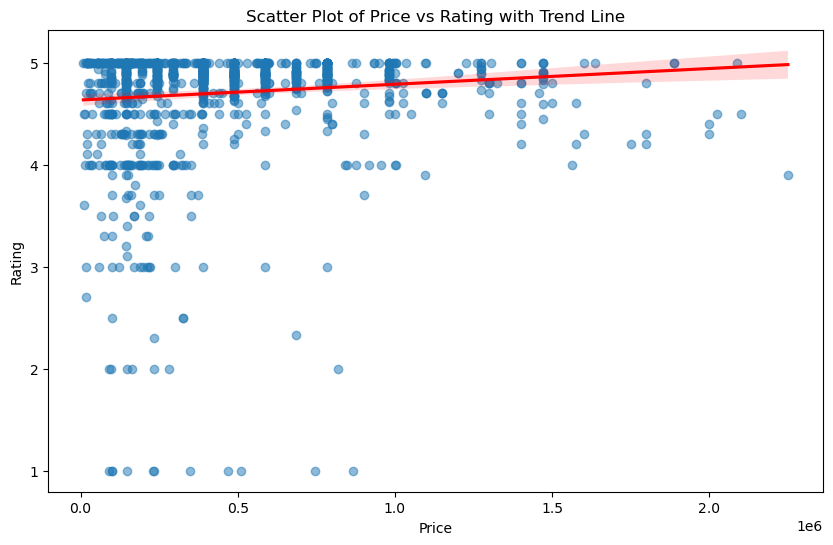

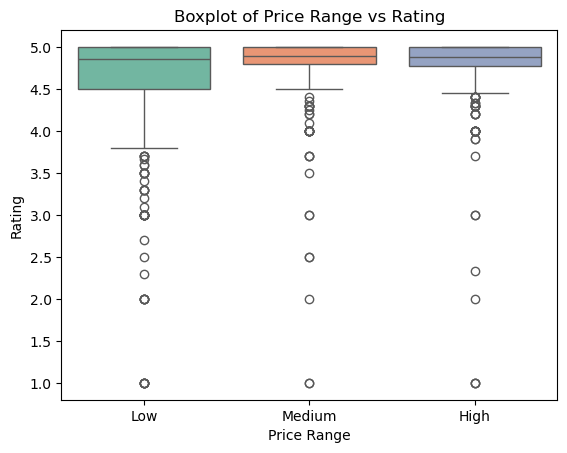

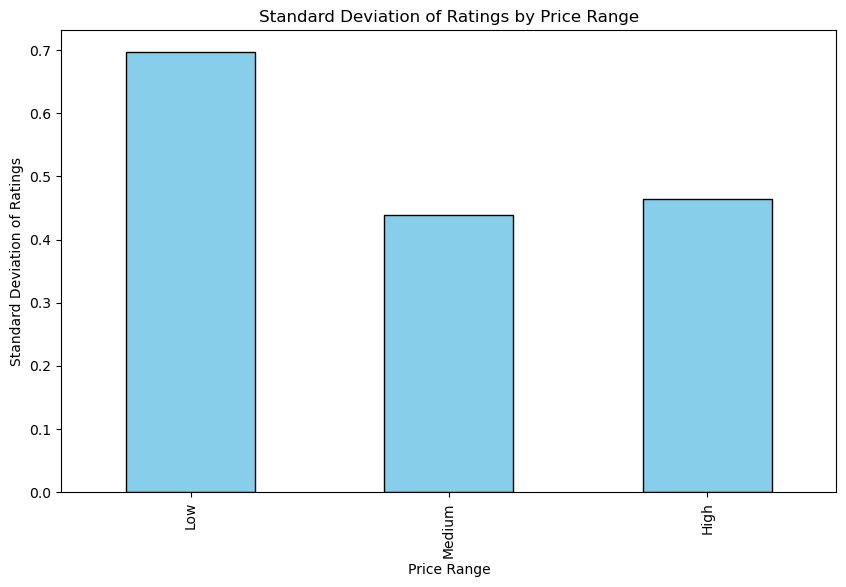

In [12]:
# Scatter Plot with Trend Line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Price', y='Rating', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Scatter Plot of Price vs Rating with Trend Line')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()

# Boxplot: Price Range vs Rating
sns.boxplot(data=df, x='Price Range', y='Rating', hue = 'Price Range',palette='Set2', legend=False)
plt.title('Boxplot of Price Range vs Rating')
plt.xlabel('Price Range')
plt.ylabel('Rating')
plt.show()

# Standard Deviation Analysis (Plot Std Dev of Ratings vs Price Range)
std_dev_ratings = df.groupby('Price Range', observed=False)['Rating'].std()
plt.figure(figsize=(10, 6))
std_dev_ratings.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Standard Deviation of Ratings by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Standard Deviation of Ratings')
plt.show()

## 4. Correlation Analysis
**Objective:**

Measure the strength and direction of the relationship between price and ratings.

**Techniques:**
- **Pearson Correlation:** Calculate the correlation coefficient.

**Steps:**

- **Calculate Correlation:** Use the ```.corr()``` method to find the correlation between ```Price``` and ```Rating```.

In [13]:
# Correlation
correlation = df['Price'].corr(df['Rating'])
print(f"Correlation between Price and Rating: {correlation:.2f}")

Correlation between Price and Rating: 0.10


## **Visualization Rating with remaining features to find the feature most strongly correlated with Rating**


### 1. Numerical Features Correlation

We'll analyze the correlation between Rating and numerical features.

Rating               1.000000
Price                0.096213
Number of Reviews    0.049456
Units Sold          -0.090399
Name: Rating, dtype: float64


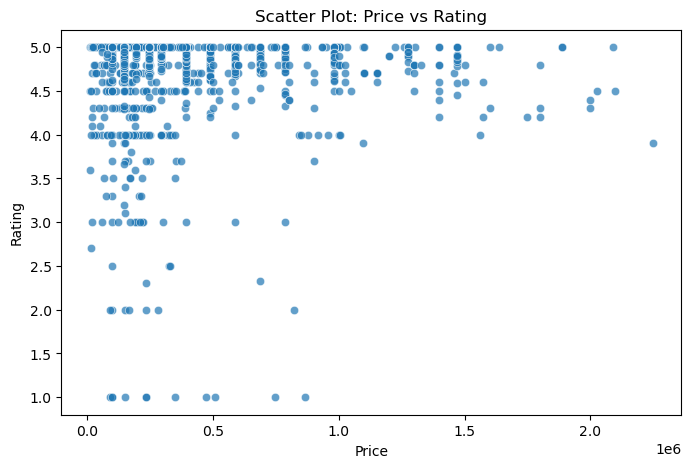

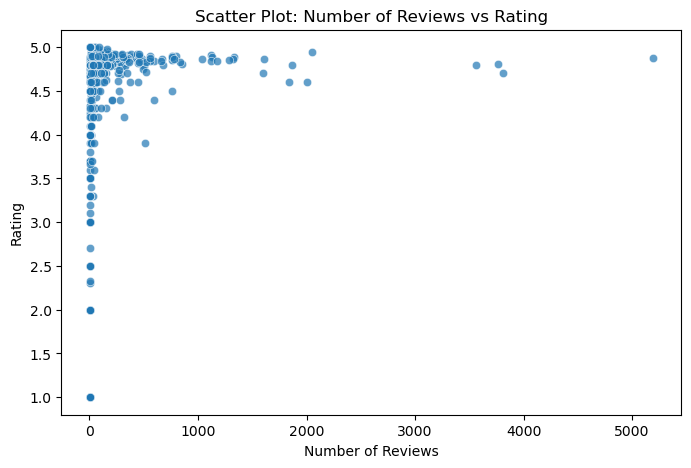

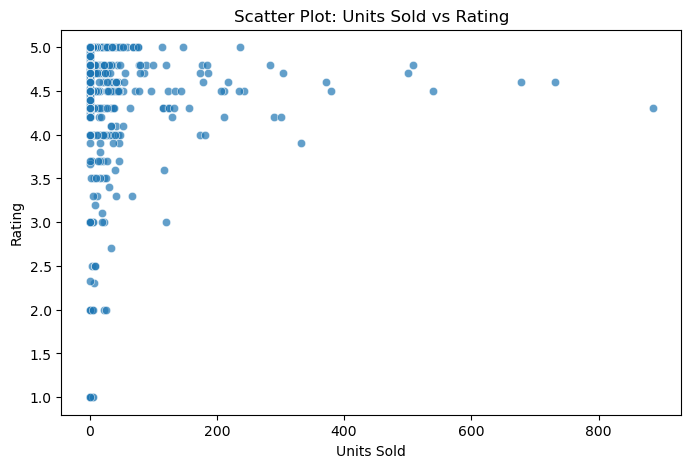

In [14]:
# Rename columns to English
df.rename(columns={
    'Tên sản phẩm': 'Product Name',
    'Tên cửa hàng': 'Store Name',
    'Giá': 'Price',
    'Thương hiệu': 'Brand',
    'Lượt đánh giá': 'Number of Reviews',
    'Điểm đánh giá trung bình': 'Rating',
    'Số lượng đã bán': 'Units Sold',
    'Category': 'Category',
    'Currency': 'Currency'
}, inplace=True)

# Select numerical features for correlation analysis
numerical_features = ['Price', 'Number of Reviews', 'Units Sold']

# Calculate correlations
correlations = df[numerical_features + ['Rating']].corr()
print(correlations['Rating'].sort_values(ascending=False))

# Scatter plots
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=feature, y='Rating', alpha=0.7)
    plt.title(f'Scatter Plot: {feature} vs Rating')
    plt.xlabel(feature)
    plt.ylabel('Rating')
    plt.show()


### 2. Categorical Features Analysis
Visualize the relationship between Rating and categorical features with boxplots.
categorical_features = ['Store Name', 'Brand', 'Category', 'Currency']

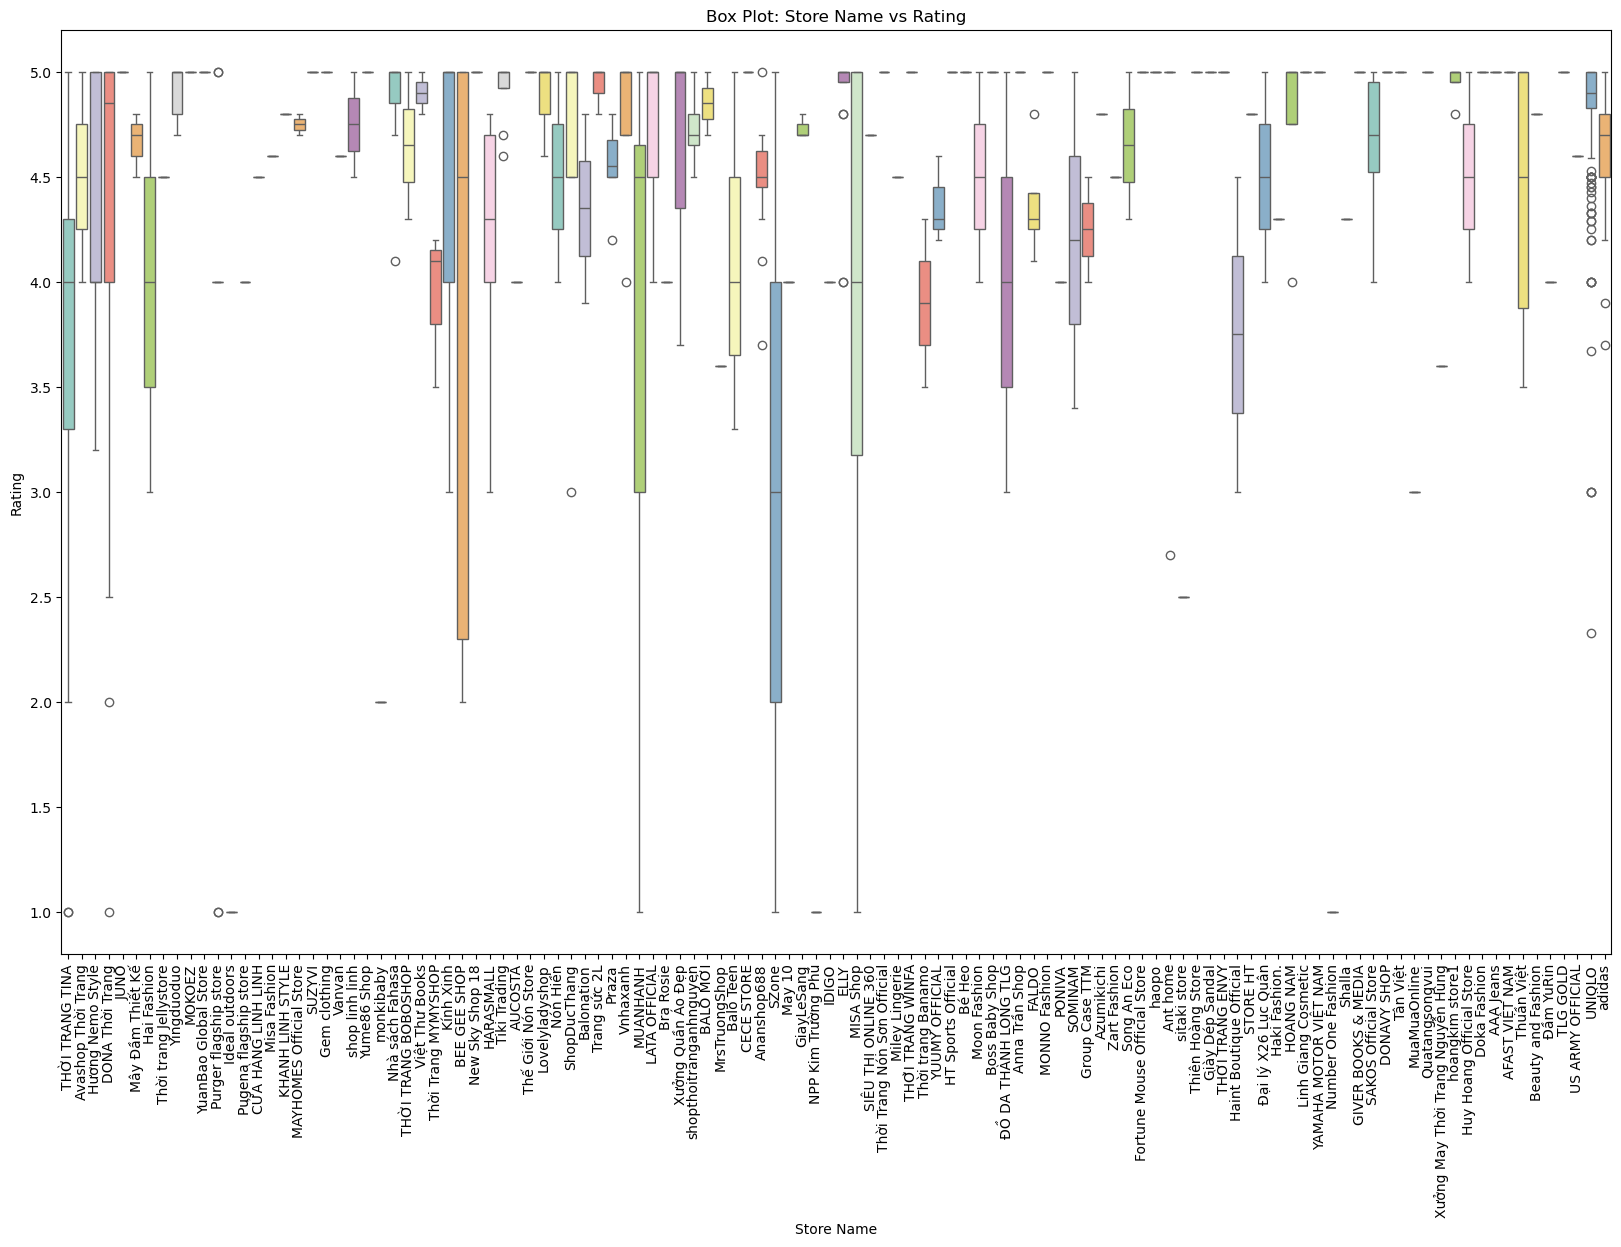

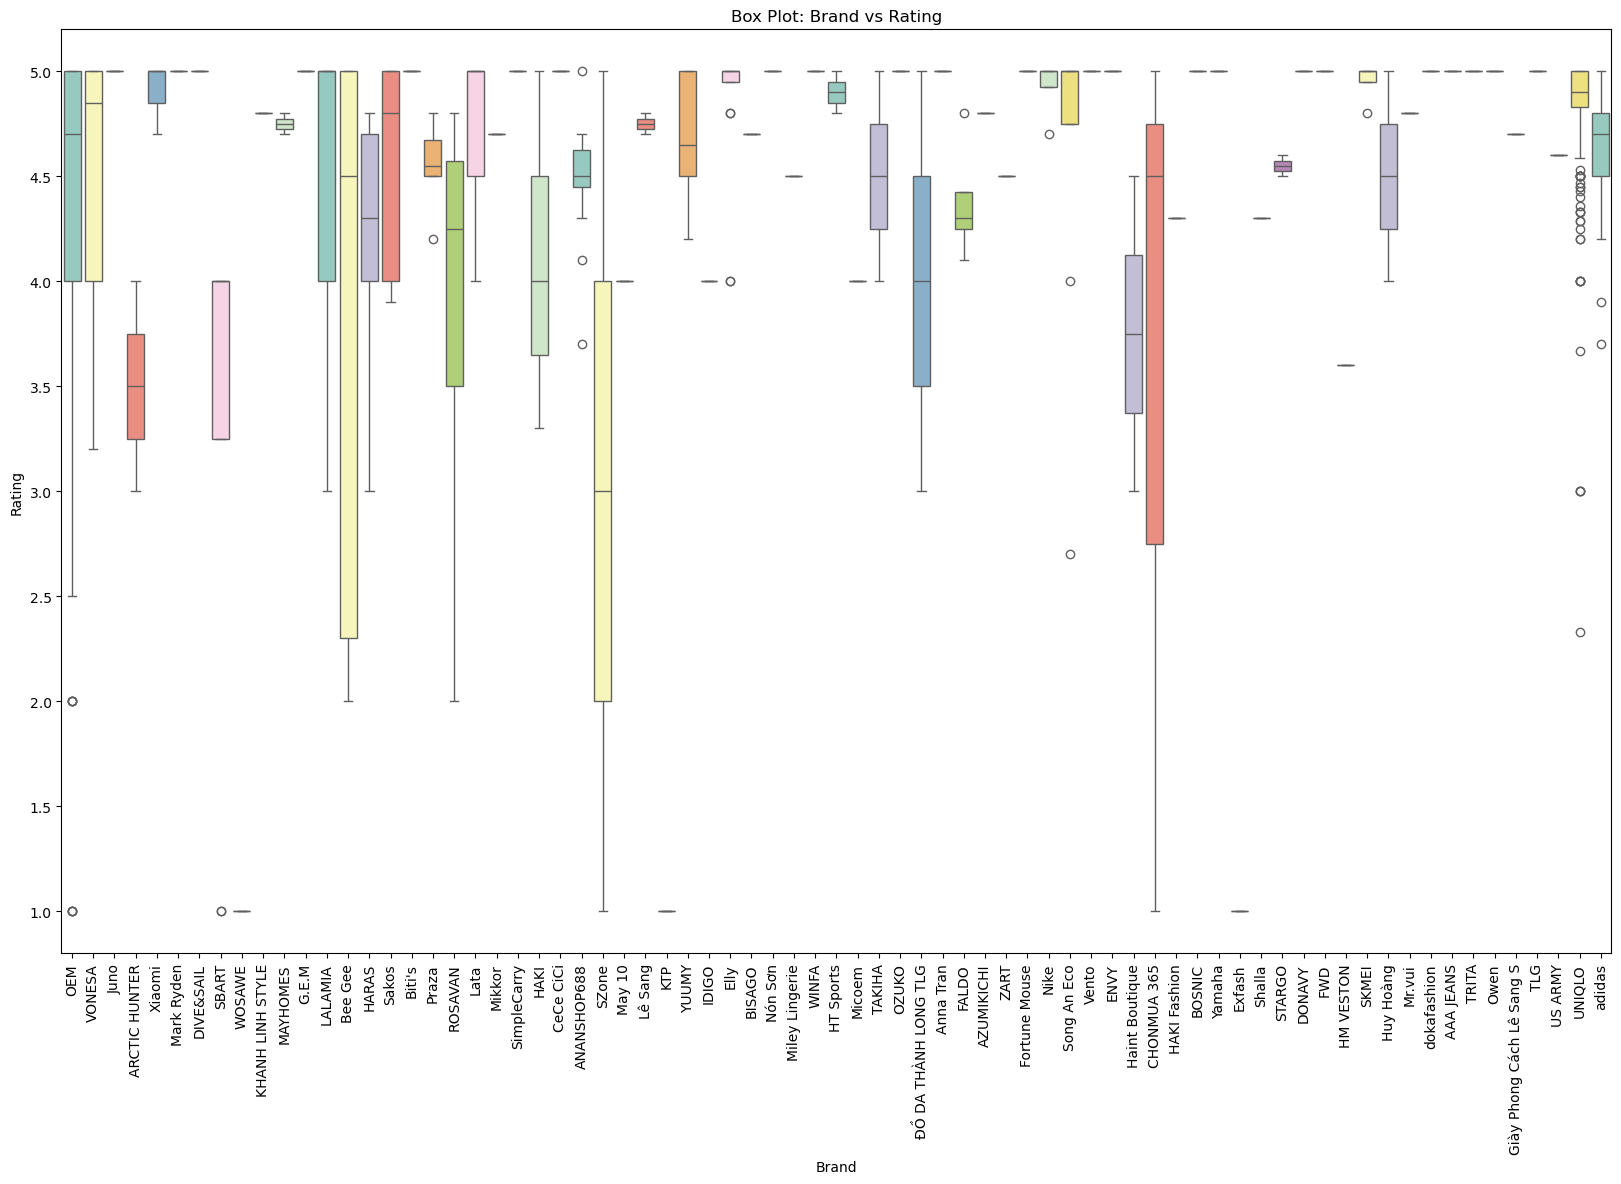

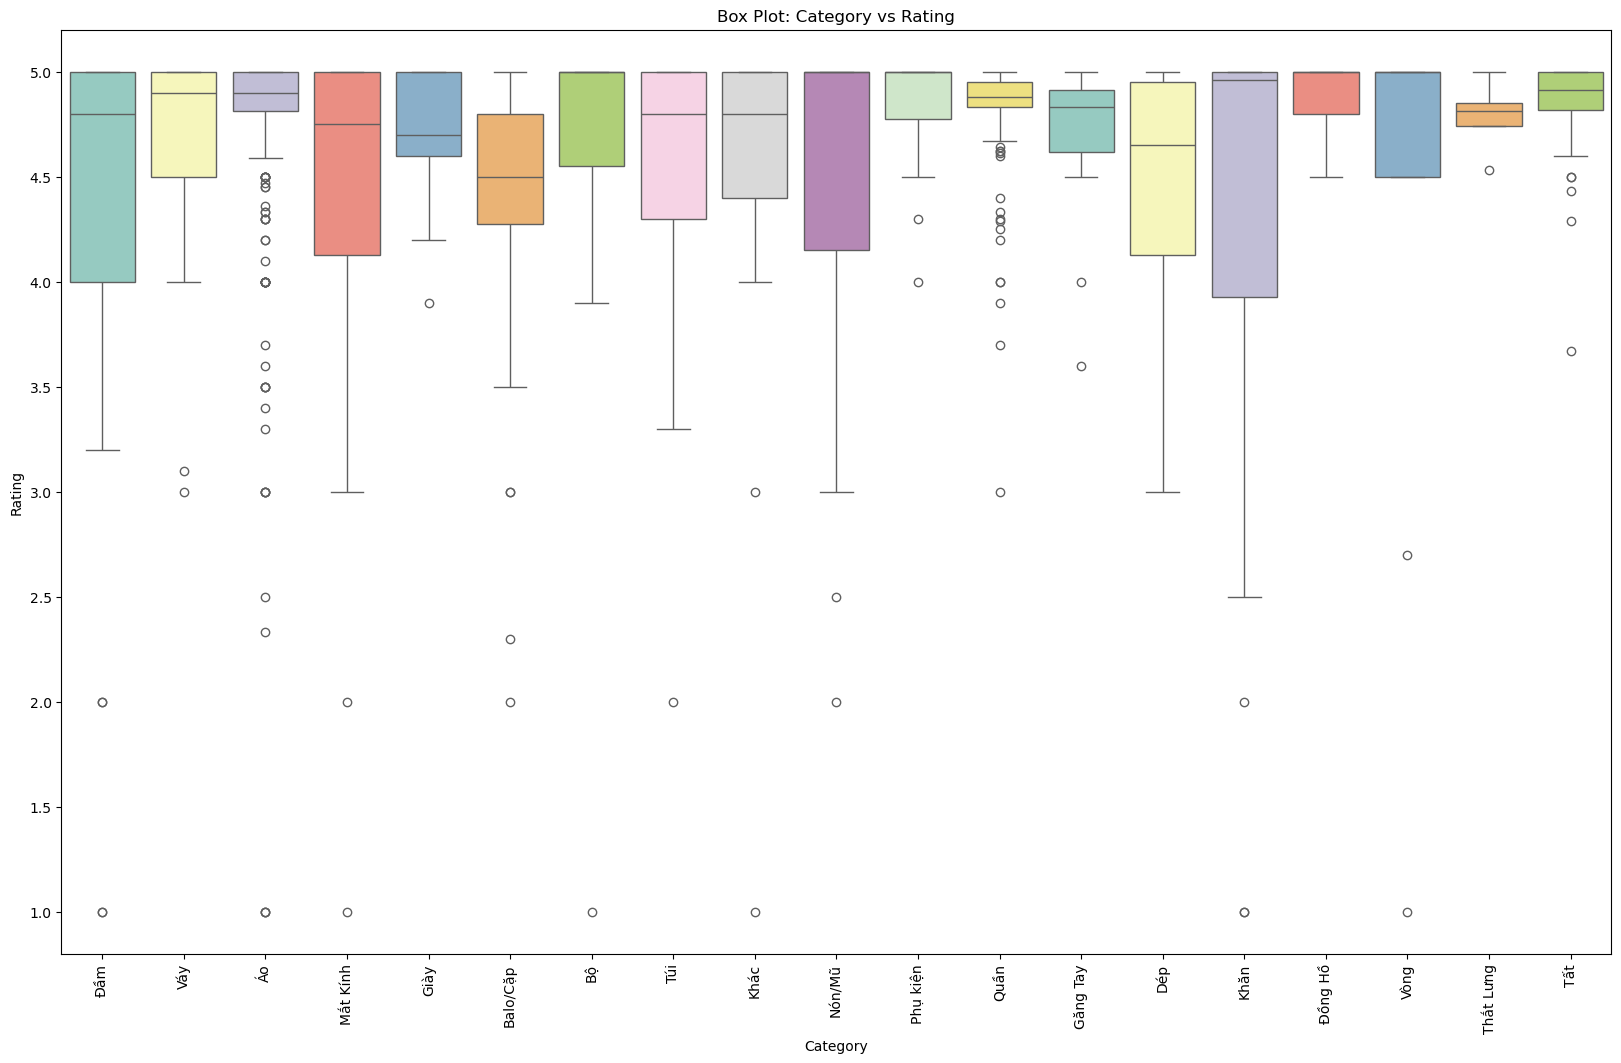

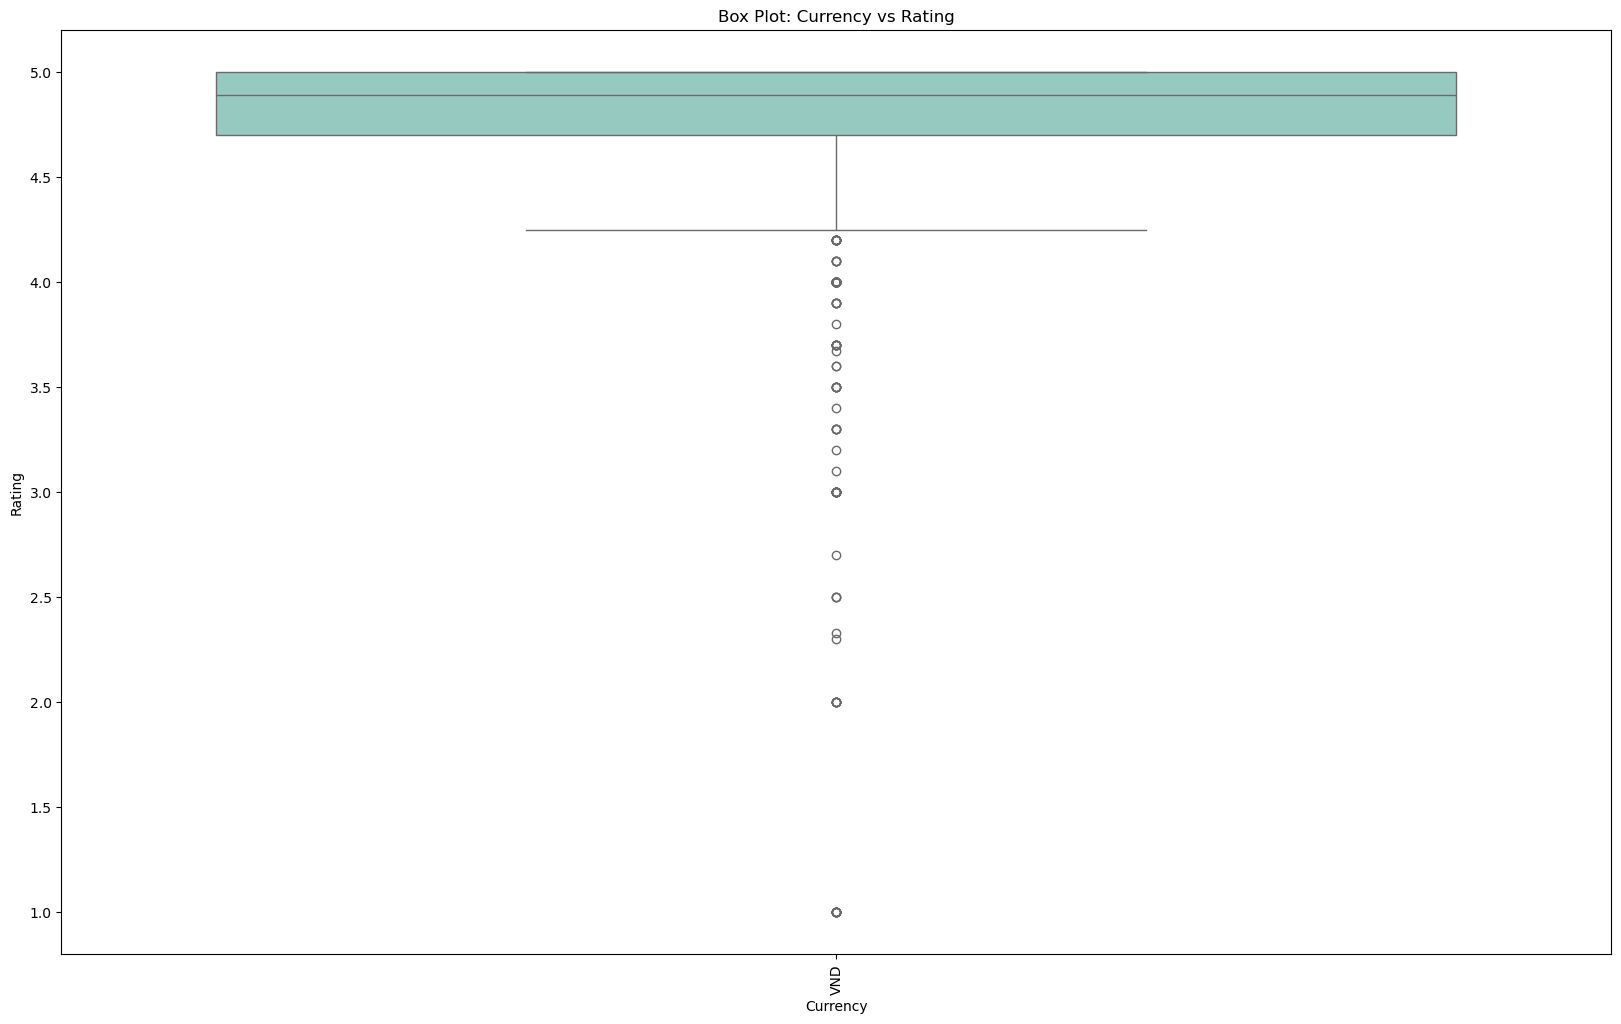

In [15]:
categorical_features = ['Store Name', 'Brand', 'Category', 'Currency']

# Box plots for categorical features
for feature in categorical_features:
    plt.figure(figsize=(20, 12))
    sns.boxplot(data=df, x=feature, y='Rating',hue=feature, palette='Set3', dodge=False)
    plt.title(f'Box Plot: {feature} vs Rating')
    plt.xlabel(feature)
    plt.ylabel('Rating')
    plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
    plt.show()


### 3. Heatmap of Correlations
Generate a heatmap for numerical features to visualize correlations.


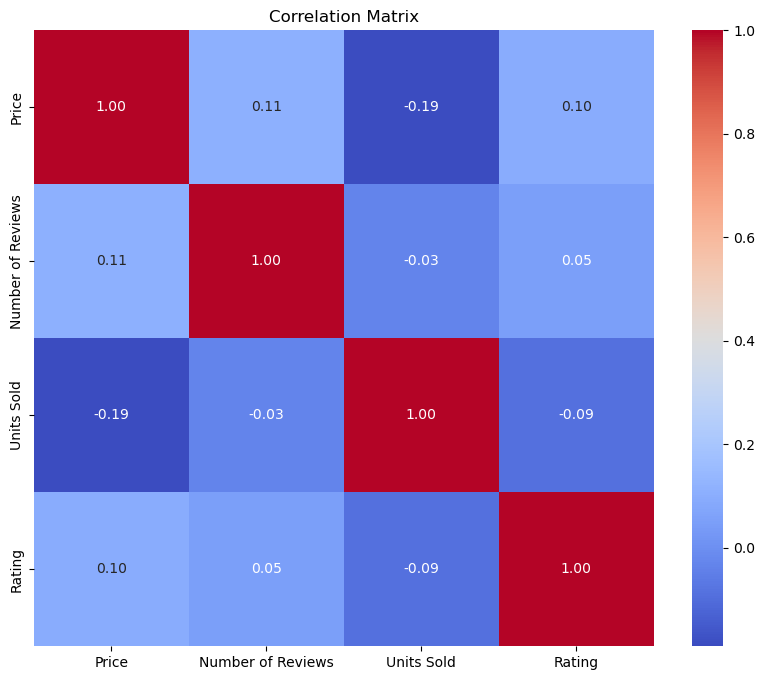

In [16]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 5. Predictive Modeling
**Objective:**

Build a regression model to predict ratings based on price and price range.

**Techniques:**

- **Linear Regression:** Model the relationship between features and the target variable.
- **Random Forest:** A tree-based ensemble method that captures complex nonlinear relationships by averaging predictions from multiple decision trees trained on random subsets of data. It is robust to overfitting when tuned properly.
- **Polynomial Regression:** Extends Linear Regression by modeling the relationship between features and the target variable as a polynomial. This captures nonlinear relationships in the data.
- **Train-Test Split:** Split the data into training and testing subsets.

**Steps:**

- **Define Features and Target:** Use ```Price Scaled``` and ```Price Range Encoded``` as features and ```Rating``` as the target.
- **Split the Data:** Split the dataset into training and testing sets.
- **Train the Model:** Fit a linear regression model.
- **Evaluate the Model:** Predict ratings and calculate performance metrics.

## **WHY CHOOSE POLYNOMIAL REGRESSION INSTEAD OF LINEAR REGRESSION?**
 Here are the main considerations:

### 1. **Nature of the Relationship**:
   - **Linear Regression** assumes a straight-line relationship between the features and the target.
      - Example: $( y = a + bx )$
   - **Polynomial Regression** captures more complex, non-linear relationships by including higher-degree terms of the features.
      - Example: $( y = a + bx + cx^2 + dx^3 + \ldots )$

   **Why Polynomial Regression?**
   If visualizations or data analysis (e.g., scatter plots) show a non-linear pattern between the features and the target, polynomial regression is better suited.


### 2. **Improved Fit**:
   - **Linear Regression** might underfit the data when the true relationship is non-linear, leading to poor predictions and low performance metrics.
   - **Polynomial Regression** can provide a better fit for complex relationships, as it adds flexibility by introducing polynomial terms.

   **Why Polynomial Regression?**
   In cases where adding polynomial terms improves metrics like \( R^2 \), Mean Squared Error (MSE), or Mean Absolute Error (MAE), polynomial regression is preferred.


### 3. **Model Complexity**:
   - **Linear Regression** is simpler and easier to interpret, but may fail for non-linear data.
   - **Polynomial Regression** increases model complexity, which can better capture non-linear patterns but may risk overfitting if the polynomial degree is too high.

   **Why Polynomial Regression?**
   If the data warrants a balance between capturing complexity and avoiding overfitting, polynomial regression with an optimal degree is a good choice.


### 4. **Insights from Data**:
   - **Linear Regression** might fail to reveal trends that require curvature (e.g., parabolic or exponential trends).
   - **Polynomial Regression** can highlight such trends, providing better insights into the relationship.

   **Why Polynomial Regression?**
   If your domain knowledge or exploratory analysis suggests a non-linear interaction, polynomial regression can uncover these insights.


In summary, polynomial regression is chosen over linear regression when the data exhibits a non-linear relationship that cannot be adequately modeled using a straight line.

=== Polynomial Regression ===
Polynomial MAE: 0.32
Polynomial MSE: 0.27
Polynomial R-squared: 0.03

=== Random Forest Regressor ===
Random Forest MAE: 0.30
Random Forest MSE: 0.32
Random Forest R-squared: -0.16


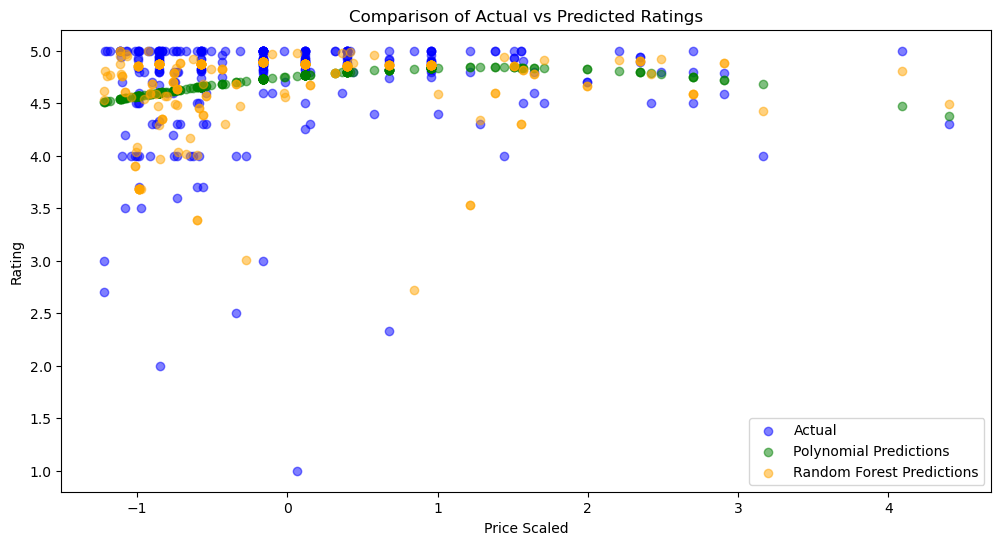

In [17]:
# Features and target
X = df[['Price Scaled']]
y = df['Rating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Polynomial Regression
print("=== Polynomial Regression ===")
poly = PolynomialFeatures(degree=2)  # Try degree=2 or 3
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
y_poly_pred = poly_model.predict(X_poly_test)

# Evaluate Polynomial Regression
poly_mae = mean_absolute_error(y_test, y_poly_pred)
poly_mse = mean_squared_error(y_test, y_poly_pred)
poly_r2 = r2_score(y_test, y_poly_pred)

print(f"Polynomial MAE: {poly_mae:.2f}")
print(f"Polynomial MSE: {poly_mse:.2f}")
print(f"Polynomial R-squared: {poly_r2:.2f}")

# 2. Random Forest Regressor
print("\n=== Random Forest Regressor ===")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

# Evaluate Random Forest Regressor
rf_mae = mean_absolute_error(y_test, y_rf_pred)
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest MSE: {rf_mse:.2f}")
print(f"Random Forest R-squared: {rf_r2:.2f}")

# Visualize Results
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, alpha=0.5, label="Actual", color="blue")
plt.scatter(X_test, y_poly_pred, alpha=0.5, label="Polynomial Predictions", color="green")
plt.scatter(X_test, y_rf_pred, alpha=0.5, label="Random Forest Predictions", color="orange")
plt.legend()
plt.title("Comparison of Actual vs Predicted Ratings")
plt.xlabel("Price Scaled")
plt.ylabel("Rating")
plt.show()

## 6. Statistical Testing
**Objective:**

Determine if the rating distributions differ significantly among price ranges.

**Techniques:**
- **ANOVA (Analysis of Variance):** Compare means across multiple groups.
- **Assumptions of ANOVA:**
    1. **Normality:** Ratings within each group are normally distributed.
    2. **Homogeneity of Variance:** Variances across groups are approximately equal.
    3. **Independence:** Observations are independent of each other.

**Steps:**
1. **Define Hypotheses:**
    - Null Hypothesis (H₀): The mean ratings are equal across all price ranges (Low, Medium, High).
    - Alternative Hypothesis (H₁): At least one price range has a different mean rating.

2. **Group Ratings by Price Range:** Extract ratings for each price range.

3. **Validate ANOVA Assumptions:**
    - **Test Normality** using the Shapiro-Wilk test.
    - **Test Homogeneity of Variance** using Levene’s test.

4. **Perform ANOVA:**
Conduct a one-way ANOVA test to compare means across groups.

5. **Interpret Results:**

    - A **p-value < 0.05** indicates significant differences in mean ratings across price ranges.
    - Identify null value thresholds (missing or invalid ranges) and exclude them.

**Interpretation:**

1. **Null Hypothesis (H₀):** The mean ratings are equal across all price ranges.

    - **If p-value < 0.05**, reject H₀ and conclude that there are significant differences between groups.
    - **If p-value ≥ 0.05**, fail to reject H₀, indicating no significant differences.

2. **Handling Null Values:**

    - Before performing ANOVA, check and remove rows with missing or invalid values in the ```Rating``` or ```Price Range``` columns to ensure clean data.

3. **Assumptions Validation:**

    - Normality ensures the reliability of statistical inferences.
    - Homogeneity of variance ensures fair comparisons across groups.

4. **Use Case for Null Values:**

    - Highlight any price range with insufficient data or null ratings. Such cases might skew the results and should be excluded from analysis.



In [18]:
# ANOVA test to check differences between price groups
low = df[df['Price Range'] == 'Low']['Rating']
medium = df[df['Price Range'] == 'Medium']['Rating']
high = df[df['Price Range'] == 'High']['Rating']

# 1. Test Normality (Shapiro-Wilk test)
_, p_low_normality = shapiro(low)
_, p_medium_normality = shapiro(medium)
_, p_high_normality = shapiro(high)
print(f"Shapiro-Wilk p-values: Low: {p_low_normality:.4f}, Medium: {p_medium_normality:.4f}, High: {p_high_normality:.4f}")

# 2. Test Homogeneity of Variance (Levene’s test)
_, p_levene = levene(low, medium, high)
print(f"Levene's test p-value: {p_levene:.4f}")

# Proceed with ANOVA only if assumptions are met
if all(p > 0.05 for p in [p_low_normality, p_medium_normality, p_high_normality]) and p_levene > 0.05:
    # Perform ANOVA
    f_stat, p_value = f_oneway(low, medium, high)
    print(f"ANOVA F-statistic: {f_stat:.2f}, P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("The mean ratings differ significantly among price ranges.")
    else:
        print("No significant differences in mean ratings among price ranges.")
else:
    print("ANOVA assumptions not met. Results may not be reliable.")

Shapiro-Wilk p-values: Low: 0.0000, Medium: 0.0000, High: 0.0000
Levene's test p-value: 0.0000
ANOVA assumptions not met. Results may not be reliable.


## 7. Expected Outcomes

1. **Dataset Overview and Preparation**:
   - A clean and well-structured dataset with consistent column names.
   - Removal of outliers to ensure a more accurate analysis.
   - Standardized `Price` values for effective comparisons and feature scaling.

2. **Segmentation by Price Range**:
   - Successful categorization of products into three price ranges: `Low`, `Medium`, and `High`.
   - Balanced distribution of products among price ranges to avoid bias.

3. **Correlation Analysis**:
   - Quantification of the relationship between `Price` and `Rating` through correlation coefficients.
   - Insights into whether higher-priced products tend to have higher ratings.

4. **Visualization Insights**:
   - Scatter plot displaying the relationship between `Price (Scaled)` and `Rating`, segmented by `Price Range`.
   - Boxplot showing the spread and distribution of `Rating` within each `Price Range`, highlighting potential differences.

5. **Standard Deviation Analysis**:
   - Computation of the standard deviation of `Rating` for each `Price Range` to understand variability.
   - A bar chart showcasing the differences in variability of `Rating` across price ranges.

6. **Model Training and Evaluation**:
   - A trained Polynomial Regression & Random Forest model predicting `Rating` based on `Price (Scaled)` and `Price Range`.
   - Evaluation metrics including MAE, MSE, and R², providing insight into the model’s performance.
   - Identification of the model’s predictive accuracy and potential areas for improvement.

7. **ANOVA Test**:
   - Statistical test results (F-statistic and p-value) to determine significant differences in `Rating` across the `Low`, `Medium`, and `High` price ranges.
   - Insights into whether price categories significantly affect product ratings.

8. **Actionable Insights**:
   - Clear understanding of how `Price` impacts `Rating` and variability within price categories.
   - Recommendations for pricing strategies or further data collection based on the analysis.

## Conclusion Based on the Visualizations
**Boxplot of Ratings by Price Range:**

- The median rating is consistent across the three price ranges (Low, Medium, High), indicating that the central tendency of customer ratings is not significantly affected by the price range.
- However, there is some variability in ratings across all price ranges, as shown by the box heights and whiskers.
- Notably, there are outliers present in all price ranges, suggesting that some products, regardless of their price, receive significantly higher or lower ratings than the majority of products within their respective price range.

**Scatter Plot of Price vs. Rating with Trend Line:**

- **Weak Positive Correlation:** The red trend line suggests a slight positive correlation between price and rating. This indicates that, on average, higher-priced products tend to have slightly higher ratings. However, the correlation is weak, as the points are widely scattered around the trend line.
- **Significant Variability:** There is considerable variability in ratings across all price points. Many products with high prices have relatively low ratings, and vice versa. This suggests that factors other than price play a significant role in determining product ratings.
- **Outliers:** There are several outliers in the plot, which are points that deviate significantly from the general trend. These outliers represent products with unusual price-rating combinations.

**Standard Deviation of Ratings by Price Range:**

1. **Standard Deviation:** The chart illustrates the standard deviation of ratings for products across three price ranges: Low, Medium, and High. Standard deviation is a measure of how spread out the data points are from the average (mean). A higher standard deviation indicates greater variability in the ratings.

2. **Price Range and Variability:**

- **Low Price Range:** This category exhibits the highest standard deviation. This suggests that there is a greater degree of variation in customer ratings for products in the low-price range. In other words, some low-priced products are rated exceptionally high, while others receive very low ratings.

- **Medium Price Range:** The standard deviation is lower for the medium-price range compared to the low-price range. This indicates that the ratings for products in this range are more clustered around the average rating.

- **High Price Range:** The standard deviation for the high-price range is similar to that of the low-price range. This suggests a similar level of variability in ratings for high-priced products as for low-priced ones.

## Final Answer:
The analysis of the boxplot, scatter plot, and bar chart does not support the assumption that products with a high price tend to have lower ratings due to high customer expectations. While there is some variability in ratings across price ranges, the overall trend suggests that higher-priced products tend to have slightly higher ratings on average. This indicates that factors beyond price, such as product quality, brand reputation, and customer service, significantly influence customer perceptions and ultimately determine product ratings.

## References
### 1. **Statistical Techniques**: 
**ANOVA (Analysis of Variance)**
- **Purpose:** To evaluate whether there are significant differences in ratings across different price ranges.
- **Key Concepts:** F-statistic, P-value, between-group variance.
- Recommended Resources:
https://surveysparrow.com/blog/anova/
https://www.investopedia.com/terms/a/anova.asp

**Correlation Analysis**
- **Purpose:** To measure the relationship strength and direction between two variables (e.g., price and rating).
- **Key Concepts:** Correlation coefficient values range from -1 to 1.
- Recommended Resources:
https://www.investopedia.com/terms/c/correlationcoefficient.asp
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

### 2. Model Evaluation Metrics
**Mean Absolute Error (MAE)**
- **Purpose:** Evaluates the average magnitude of prediction errors, emphasizing interpretability.
- Recommended Resources:
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_absolute_error.html

**Mean Squared Error (MSE)**
- **Purpose:** Quantifies the average of squared errors, penalizing larger deviations more heavily.
- Recommended Resources:
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html

**R-squared (R²)**
- **Purpose:** Measures the proportion of variance in the dependent variable (ratings) explained by the independent variable (price).
- Recommended Resources:
https://www.investopedia.com/terms/r/r-squared.asp

### 3. Regression Analysis
**Linear Regression**
- **Purpose:** To model the relationship between price (independent variable) and rating (dependent variable).
- Recommended Resources:
https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html
https://www.geeksforgeeks.org/regression-in-machine-learning/

**Polynomial Regression:**
- **Purpose:** To assess if there is a nonlinear relationship between Price and Rating that a linear model cannot capture. By introducing polynomial terms, the goal is to see if the added complexity better explains the variability in ratings.
-Recommended Resources: https://www.analyticsvidhya.com/blog/2021/07/all-you-need-to-know-about-polynomial-regression/

**Random Forest Regressor:**
- **Purpose:** To explore whether more sophisticated tree-based models, which can capture complex and nonlinear relationships, provide better predictions. The method tests whether interactions or patterns in the data are too subtle or irregular for polynomial or linear models to identify.
- Recommended Resources: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestRegressor.html
